In [1]:
#import libraries


import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
#from Bio import SeqIO
#import filecmp
#import subprocess
#import os

%matplotlib inline

In [2]:
############################################## TEST RNA TYPE

pattern_mRNA = re.compile("spac|spap|spbp|spcc|spcp|spbc")
pattern_tRNA = re.compile("trna")
pattern_mito = re.compile("spmit")
pattern_rRNA = re.compile("rrna")
pattern_snRNA = re.compile("snrna")
pattern_snoRNA = re.compile("snorna")
pattern_ncRNA = re.compile("ncrna")


def test_RNA_type(feature_name):
    """tests for the type of tail """
    if pattern_mRNA.search(feature_name): # for example AATT
        return "mRNA"
    elif pattern_tRNA.search(feature_name): # for example AATT
        return "tRNA"
    elif pattern_mito.search(feature_name): # for example AATT
        return "mito_RNA"
    elif pattern_rRNA.search(feature_name): # for example AATT
        return "rRNA"
    elif pattern_snRNA.search(feature_name): # for example AATT
        return "snRNA"
    elif pattern_snoRNA.search(feature_name): # for example AATT
        return "snoRNA"
    elif pattern_ncRNA.search(feature_name): # for example AATT
        return "ncRNA"
    else: #only A's
        return "other_type"

assert test_RNA_type("spncrna") == "ncRNA"
assert test_RNA_type("sspcc") == "mRNA"
assert test_RNA_type("AAAAA") == "other_type"
assert test_RNA_type("TAATTT") == "other_type"

########################################### TAKE TAIL FROM CIGAR

def take_tail_fromcigar8(strand, cig, seq):
    '''
    Function returns tail seqence based on the CIGAR and sequence of read
    Input:
        cig: CIGAR from sam file after alignment qith soft-clipping  [str]
        seq: sequence of read started from 3' end, having posibble tail   [str]
    Output:
        sequence of the tail extracted from read sequence based on CIGAR [str]
    Assumptions:
        1. For tailed reads, CIGAR starts from \d+S (softcliping code). I's about the number
        of softclipped nucleotides. We assume that this is also the length of the polyA tail.
        2. Sequence seq starts from 3' tail of read.
    '''

    cigar2 = str(cig) # convert cigar to string
    if not "S" in cigar2: # return nothing if CIGAR does not contain S (soft-clipping)
        return ""
    else:  # analyze data if CIGAR starts from number and S (3' soft-clipping). If not - return nothing
        
        
        if strand =='+':      
            search_result_minus = re.findall("[0-9]+S$", cigar2)
            if search_result_minus: # find CIGARs starting from 3' soft-clipping
                number_S = int(search_result_minus[-1].split('S')[0])
                # extract number of soft-clipped nucleotides
                tail = seq[-number_S:] # extract tail (based of number of soft-clipped nucleotides)
                return tail
            else:
                return ""
        elif strand == '-':
            search_result_plus = re.findall("^[0-9]+S", cigar2)
            if search_result_plus: # find CIGARs starting from 3' soft-clipping
                number_S = int(cigar2.split('S')[0]) # extract number of soft-clipped nucleotides
                tail = seq[0:number_S] # extract tail (based of number of soft-clipped nucleotides)
                return tail
            else:
                return ""
        else:
             return ""
            
            
            
#########################

pattern_polyAU_forward3 = re.compile("^A{1,}T{2,}") # reverse transcribed
pattern_oligoU_forward3 = re.compile("^A{1,}$")
pattern_polyA_forward3 = re.compile("^T{2,}$")

pattern_polyAU_reverse3 = re.compile("A{2,}T{1,}$") # reverse transcribed
pattern_oligoU_reverse3 = re.compile("T{1,}$")
pattern_polyA_reverse3 = re.compile("A{2,}$") 

def test_tail_cigargrep8(cigar_grep, strand_R1, tail):
    """ Tests for the type of tail. Patterns are prepared for analysis of R2 read, reverse transcribed:
        base sequence start from the end of polyadenylation tail at 3' end of RNA,
        where T means adenine, and A meand uridine in the 3' tail"""
    if len(str(tail)) > 0:
        if cigar_grep=='cigar':
            if strand_R1 == '-':
                if "A" in tail:
                    if pattern_polyAU_forward3.fullmatch(tail): 
                        return "polyAU"
                    elif pattern_oligoU_forward3.fullmatch(tail): 
                        return "oligoU"
                    else:
                        return "mixed_tail"
                elif pattern_polyA_forward3.fullmatch(tail):
                        return "polyA"
                else: 
                    return "mixed_tail"
            elif strand_R1 == '+':
                if "T" in tail:
                    if pattern_polyAU_reverse3.fullmatch(tail): 
                        return "polyAU"
                    elif pattern_oligoU_reverse3.fullmatch(tail): 
                        return "oligoU"
                    else:
                        return "mixed_tail"
                elif pattern_polyA_reverse3.fullmatch(tail):
                        return "polyA"
                else: 
                    return "mixed_tail"
            else: 
                    return "strand_nn"
        elif cigar_grep=='grep':
            if strand_R1 == '+':
                if "A" in tail:
                    if pattern_polyAU_forward3.fullmatch(tail): 
                        return "polyAU"
                    elif pattern_oligoU_forward3.fullmatch(tail): 
                        return "oligoU"
                    else:
                        return "mixed_tail_grep"
                elif pattern_polyA_forward3.fullmatch(tail):
                        return "polyA"
                else: 
                    return "mixed_tail"
            elif strand_R1 == '-':
                if "A" in tail:
                    if pattern_polyAU_forward3.fullmatch(tail): 
                        return "polyAU"
                    elif pattern_oligoU_forward3.fullmatch(tail): 
                        return "oligoU"
                    else:
                        return "mixed_tail_grep"
                elif pattern_polyA_forward3.fullmatch(tail):
                        return "polyA"
                else: 
                    return "mixed_tail"
            else:
                return "nocigar_grep"
        else:
            return "without_tail"
    elif len(str(tail)) <1:
        if cigar_grep=='cigar':
            return "no_tail"
        elif cigar_grep =='grep':
            return "mixed_tail"
        else:
            return "jakis_bias"
            
    
    else: 
        return 'jakis_bias'
    
#######################

def grep_tail_edit_onlyfromSeq(seq):
    '''
    Function ....
    '''

    search_result_plus = re.findall("^[A]{0,}[T]{0,}", seq)
    if search_result_plus: # find CIGARs starting from 3' soft-clipping
        return search_result_plus[0]
    else:
        return ""


def tail_fromGREPorCIGAR_description(cigar, tailGrep, tailCigar):
    if cigar == '*':
        return 'grep'
    else:
        return 'cigar'
    

def tail_fromGREPorCIGAR(cigar, tailGrep, tailCigar):
    if cigar == '*':
        return tailGrep
    else:
        return tailCigar
    
##########################################333
import re

def flag_16_coordinate(cigar):
    cigar_sum_len = sum([int(s.strip('MND')) for s in re.findall(r'\d+[MND]', cigar)])
    return(cigar_sum_len)

def stop_based_on_cigar(cigar, strand_R1, coord_R2):
    if cigar == '*':
        return 0
    elif  cigar != '*':
        if strand_R1 == '-':
            stop_R2 = coord_R2 -1
            return stop_R2
        elif strand_R1 == '+' :
            distance = flag_16_coordinate(cigar)
            stop_R2 = coord_R2 -1 + distance
            return stop_R2
        else:
            return 'cigar_but_unknown_strand'
    else:
        return 0
        
def distance_to_TES(cigar, strand_R1, stop_R2, gene_start,gene_stop):
    if cigar == '*':
        return 0
    elif  cigar != '*':
        if strand_R1 == '-':
            distance_to_TES = gene_start - stop_R2
            return distance_to_TES
        elif strand_R1 == '+' :
            distance_to_TES = stop_R2 - gene_stop
            return distance_to_TES
        else:
            return 0
    else:
        return 0

    


In [ ]:
### na pliku od Michala (MM WT 76) / probka wt od Borny

#df = pd.read_csv('/home/lidia/Documents/seqlab_sshfs/home/llipinska/workdir/tailseq_skryptyMM_wrzesien2022/output_delta_cid1delta_cid16_clone1_20220830/output_short.tab', 

df = pd.read_csv('/home/lidia/Documents/seqlab_sshfs/home/llipinska/workdir/tailseq_skryptyMM_wrzesien2022/output_Wild_type_clone2_20220830/output_short.tab', sep = '\t',
                 names = ['read_ID', 'chr', 'start_R1', 'stop_R1','strand_R1', 'gene_start', 'gene_stop',
                         'gene','coord_R2', 'cigar', 'seq_R2'])

df['RNA_type'] = df['gene'].apply(lambda x: test_RNA_type(x.lower()))
df['tail_fromcigar'] = df.apply(lambda kol: take_tail_fromcigar8(kol.strand_R1, kol.cigar,  kol.seq_R2), 
                                axis = 1)
df['tail_LENcigar'] = df['tail_fromcigar'].apply(lambda x: len(x))
df['tail_fromGREP'] = df.apply(lambda kol: grep_tail_edit_onlyfromSeq(kol.seq_R2), axis = 1)

#df = df.drop_duplicates()
df['tail_GreporCigar'] = df.apply(lambda kol: tail_fromGREPorCIGAR(kol.cigar, kol.tail_fromGREP, kol.tail_fromcigar),axis = 1)


                                                                                    
df['tail_from'] = df.apply(lambda kol: tail_fromGREPorCIGAR_description(kol.cigar,
                                                                        kol.tail_fromGREP,kol.tail_fromcigar),
                           axis = 1)
df['tail_len'] = df['tail_GreporCigar'].apply(lambda x: len(x))
#df = df[df['tail_len']>0]
df['tail_type'] = df.apply(lambda kol:   test_tail_cigargrep8(kol.tail_from, kol.strand_R1, kol.tail_GreporCigar),axis = 1)
  

df['stop_R2'] =  df.apply(lambda kol: stop_based_on_cigar(kol.cigar, kol.strand_R1 , kol.coord_R2),axis = 1)
df['distance_to_TES'] =  df.apply(lambda kol: distance_to_TES(kol.cigar,kol.strand_R1 ,kol.stop_R2,
                                                              kol.gene_start,kol.gene_stop),axis = 1)

df['gene_len'] = df['gene_stop']-df['gene_start']
df['rel_distance_to_TES'] = df['distance_to_TES']/df['gene_len']
df.to_csv('/home/lidia/Documents/seqlab_sshfs/home/llipinska/workdir/tailseq_skryptyMM_wrzesien2022/output_Wild_type_clone2_20220830/df_output_Wild_type_clone2_distanceMM_221004.csv')
    

In [4]:
df.shape

(9728191, 23)

(array([     0.,  20000.,  40000.,  60000.,  80000., 100000.]),
 <a list of 6 Text yticklabel objects>)

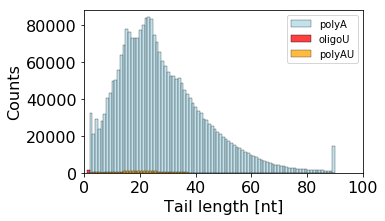

In [4]:
data2 = df[df['RNA_type']=='mRNA']
data2 = data2[data2['tail_len']<101]


polyA = data2[data2['tail_type']=='polyA']
polyAU = data2[data2['tail_type']=='polyAU']
oligoU = data2[data2['tail_type']=='oligoU']

f, ax = plt.subplots(figsize=(5, 3))
sns.histplot(polyA['tail_len'], color = 'lightblue', bins = len(polyA['tail_len'].unique()), 
                 label ='polyA')
    
sns.histplot(oligoU['tail_len'], color = 'red', bins = len(oligoU['tail_len'].unique()),
                label = 'oligoU')
sns.histplot(polyAU['tail_len'], color = 'orange', bins = len(polyAU['tail_len'].unique()),
                label ='polyAU')
#sns.histplot(without_tail['tail_len_FINAL'], color = 'yellow')

plt.xlim([1,50])
#ax.set_title('{}, mRNA'.format(name_short), fontsize =18)
plt.xlabel('Tail length [nt]', size=16)
plt.ylabel('Counts', size=16)
plt.legend()

plt.xticks(fontsize=16)
ax.set(xlim=(0, 100))
    #ax.set(ylim=(0, 20500))
plt.yticks(fontsize=16)

In [11]:
df.shape

(3413328, 23)

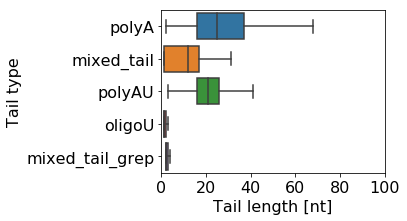

In [5]:
data = df[df['RNA_type']=='mRNA']
data = data[data['tail_type']!= 'without_tail']
data = data[data['tail_type']!= 'without_tail_nan']
   
f, ax =plt.subplots(figsize=(4,3))
    #f =df['tail_type_FINAL'].value_counts().plot(kind='bar')
sns.boxplot(data = data, x = 'tail_len', y = 'tail_type', showfliers=False)#, hue = 'tail_from' )#'strand_x'
              # hue='tail_from')#,order = order_tails)
#ax.set_title('{}, mRNA'.format(name_short), fontsize =18)
plt.xlabel('Tail length [nt]', size=16)
plt.ylabel('Tail type', size=16)

plt.xticks(fontsize=16)
ax.set(xlim=(0, 100))
plt.yticks(fontsize=16)
plt.show()